# Clone Github

In [6]:
!git lfs install
!git clone https://github.com/soCzech/TransNetV2
%cd TransNetV2/inference-pytorch

Updated git hooks.
Git LFS initialized.
Cloning into 'TransNetV2'...
remote: Enumerating objects: 362, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 362 (delta 71), reused 71 (delta 71), pack-reused 274 (from 1)
Receiving objects: 100% (362/362), 95.25 KiB | 5.95 MiB/s, done.
Resolving deltas: 100% (210/210), done.
Error downloading object: inference/transnetv2-weights/saved_model.pb (8ac2a52): Smudge error: Error downloading inference/transnetv2-weights/saved_model.pb (8ac2a52c5719690d512805b6eaf5ce12097c1d8860b3d9de245dcbbc3100f554): batch response: This repository exceeded its LFS budget. The account responsible for the budget should increase it to restore access.

Errors logged to /kaggle/working/TransNetV2/inference-pytorch/TransNetV2/.git/lfs/logs/20250823T054145.199316705.log
Use `git lfs logs last` to view the log.
error: external filter 'git-lfs filter-process' failed
fatal: inference/transnetv2-weights/saved

# Import thư viện

In [7]:
import cv2
import torch
import numpy as np
from transnetv2_pytorch import TransNetV2
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Load Model

In [8]:
# ==== 1. Load model ====
model = TransNetV2()
state_dict = torch.load("/kaggle/input/transnetv2-pytorch/pytorch/default/1/transnetv2-pytorch-weights.pth", map_location="cuda")
model.load_state_dict(state_dict)
model.eval().cuda()

TransNetV2(
  (SDDCNN): ModuleList(
    (0): StackedDDCNNV2(
      (DDCNN): ModuleList(
        (0): DilatedDCNNV2(
          (Conv3D_1): Conv3DConfigurable(
            (layers): ModuleList(
              (0): Conv3d(3, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
              (1): Conv3d(32, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
            )
          )
          (Conv3D_2): Conv3DConfigurable(
            (layers): ModuleList(
              (0): Conv3d(3, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
              (1): Conv3d(32, 16, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(2, 0, 0), dilation=(2, 1, 1), bias=False)
            )
          )
          (Conv3D_4): Conv3DConfigurable(
            (layers): ModuleList(
              (0): Conv3d(3, 32, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
              (1): Conv3d(32, 16, kernel_size=(3, 1, 1), 

# Khởi tạo hàm predict shot boundary

In [9]:
def extract_frames_with_opencv(video_path: str, target_height: int = 27, target_width: int = 48, show_progressbar: bool = False):
    """
    Extracts frames from a video using OpenCV with optional CUDA support and progress tracking.
    """
    logger.info(f"Opening video: {video_path}")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        logger.error(f"Failed to open video: {video_path}")
        raise ValueError(f"Failed to open video: {video_path}")

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frames = []

    # Initialize progress bar
    progress_bar = tqdm(total=total_frames, desc="Extracting frames", unit="frame") if show_progressbar else None

    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # Convert frame to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # Resize frame
        frame_resized = cv2.resize(frame_rgb, (target_width, target_height))
        frames.append(frame_resized)
        if progress_bar:
            progress_bar.update(1)

    cap.release()
    if progress_bar:
        progress_bar.close()
    logger.info(f"Extracted {len(frames)} frames")
    return np.array(frames)

def input_iterator(frames):
    """
    Generator that yields batches of 100 frames, with padding at the beginning and end.
    """
    no_padded_frames_start = 25
    no_padded_frames_end = 25 + 50 - (len(frames) % 50 if len(frames) % 50 != 0 else 50)

    start_frame = np.expand_dims(frames[0], 0)
    end_frame = np.expand_dims(frames[-1], 0)
    padded_inputs = np.concatenate(
        [start_frame] * no_padded_frames_start +
        [frames] +
        [end_frame] * no_padded_frames_end, 0
    )

    ptr = 0
    while ptr + 100 <= len(padded_inputs):
        out = padded_inputs[ptr:ptr + 100]
        ptr += 50
        yield out[np.newaxis]

def predictions_to_scenes(predictions: np.ndarray, threshold: float = 0.5):
    """
    Converts model predictions to scene boundaries based on a threshold.
    """
    predictions = (predictions > threshold).astype(np.uint8)

    scenes = []
    t, t_prev, start = -1, 0, 0
    for i, t in enumerate(predictions):
        if t_prev == 1 and t == 0:
            start = i
        if t_prev == 0 and t == 1 and i != 0:
            scenes.append([start, i])
        t_prev = t
    if t == 0:
        scenes.append([start, i])

    if len(scenes) == 0:
        return np.array([[0, len(predictions) - 1]], dtype=np.int32)

    return np.array(scenes, dtype=np.int32)

def predict_raw(model, video, device=torch.device('cuda:0')):
    """
    Performs inference on the video using the TransNetV2 model.
    """
    model.to(device)
    with torch.no_grad():
        predictions = []
        for inp in input_iterator(video):
            video_tensor = torch.from_numpy(inp).to(device)
            single_frame_pred, all_frame_pred = model(video_tensor)
            single_frame_pred = torch.sigmoid(single_frame_pred).cpu().numpy()
            all_frame_pred = torch.sigmoid(all_frame_pred["many_hot"]).cpu().numpy()
            predictions.append(
                (single_frame_pred[0, 25:75, 0], all_frame_pred[0, 25:75, 0]))
        single_frame_pred = np.concatenate([single_ for single_, _ in predictions])
        return video.shape[0], single_frame_pred

def predict_video(video_path: str, device: str = 'cuda', show_progressbar: bool = False):
    """
    Detects shot boundaries in a video file using the TransNetV2 model.
    """
    # Determine device
    if device == 'cuda' and torch.cuda.is_available():
        device = torch.device('cuda')
        logger.info(f"Using GPU: {torch.cuda.get_device_name(device)}")
    else:
        device = torch.device('cpu')
        logger.info("Using CPU")

    frames = extract_frames_with_opencv(video_path, show_progressbar=show_progressbar)
    _, single_frame_pred = predict_raw(model, frames, device=device)
    scenes = predictions_to_scenes(single_frame_pred)
    logger.info(f"Detected {len(scenes)} scenes")
    return scenes

# Predict shot boundary

In [10]:
video_path = "/kaggle/input/keyframes-sample/L21_V001 (online-video-cutter.com).mp4"
scenes = predict_video(video_path, show_progressbar=True)
print(scenes)

Extracting frames: 100%|██████████| 13052/13052 [00:21<00:00, 611.46frame/s]


[[    0    52]
 [   54   342]
 [  343   410]
 [  411   457]
 [  458   509]
 [  510   564]
 [  565   611]
 [  612   660]
 [  661   761]
 [  762   856]
 [  857   920]
 [  921  1886]
 [ 1887  2035]
 [ 2036  2130]
 [ 2131  2216]
 [ 2217  2287]
 [ 2288  2374]
 [ 2375  2411]
 [ 2412  2574]
 [ 2575  2719]
 [ 2720  2815]
 [ 2816  2856]
 [ 2857  2958]
 [ 2959  3242]
 [ 3243  3347]
 [ 3348  3407]
 [ 3408  3583]
 [ 3584  3618]
 [ 3619  3677]
 [ 3678  3781]
 [ 3782  3856]
 [ 3857  3931]
 [ 3932  4036]
 [ 4037  4183]
 [ 4184  4307]
 [ 4308  4428]
 [ 4429  4550]
 [ 4551  4686]
 [ 4687  4834]
 [ 4835  4931]
 [ 4932  4997]
 [ 4998  5082]
 [ 5083  5160]
 [ 5161  5592]
 [ 5593  6278]
 [ 6279  6385]
 [ 6386  6533]
 [ 6534  6673]
 [ 6674  6821]
 [ 6822  6932]
 [ 6933  7074]
 [ 7075  7132]
 [ 7133  7201]
 [ 7202  7811]
 [ 7812  7922]
 [ 7923  8022]
 [ 8023  8140]
 [ 8141  8272]
 [ 8273  8358]
 [ 8359  8455]
 [ 8456  8629]
 [ 8630  8729]
 [ 8730  8893]
 [ 8894  8972]
 [ 8973  9064]
 [ 9065  9198]
 [ 9199  9

# Plot result

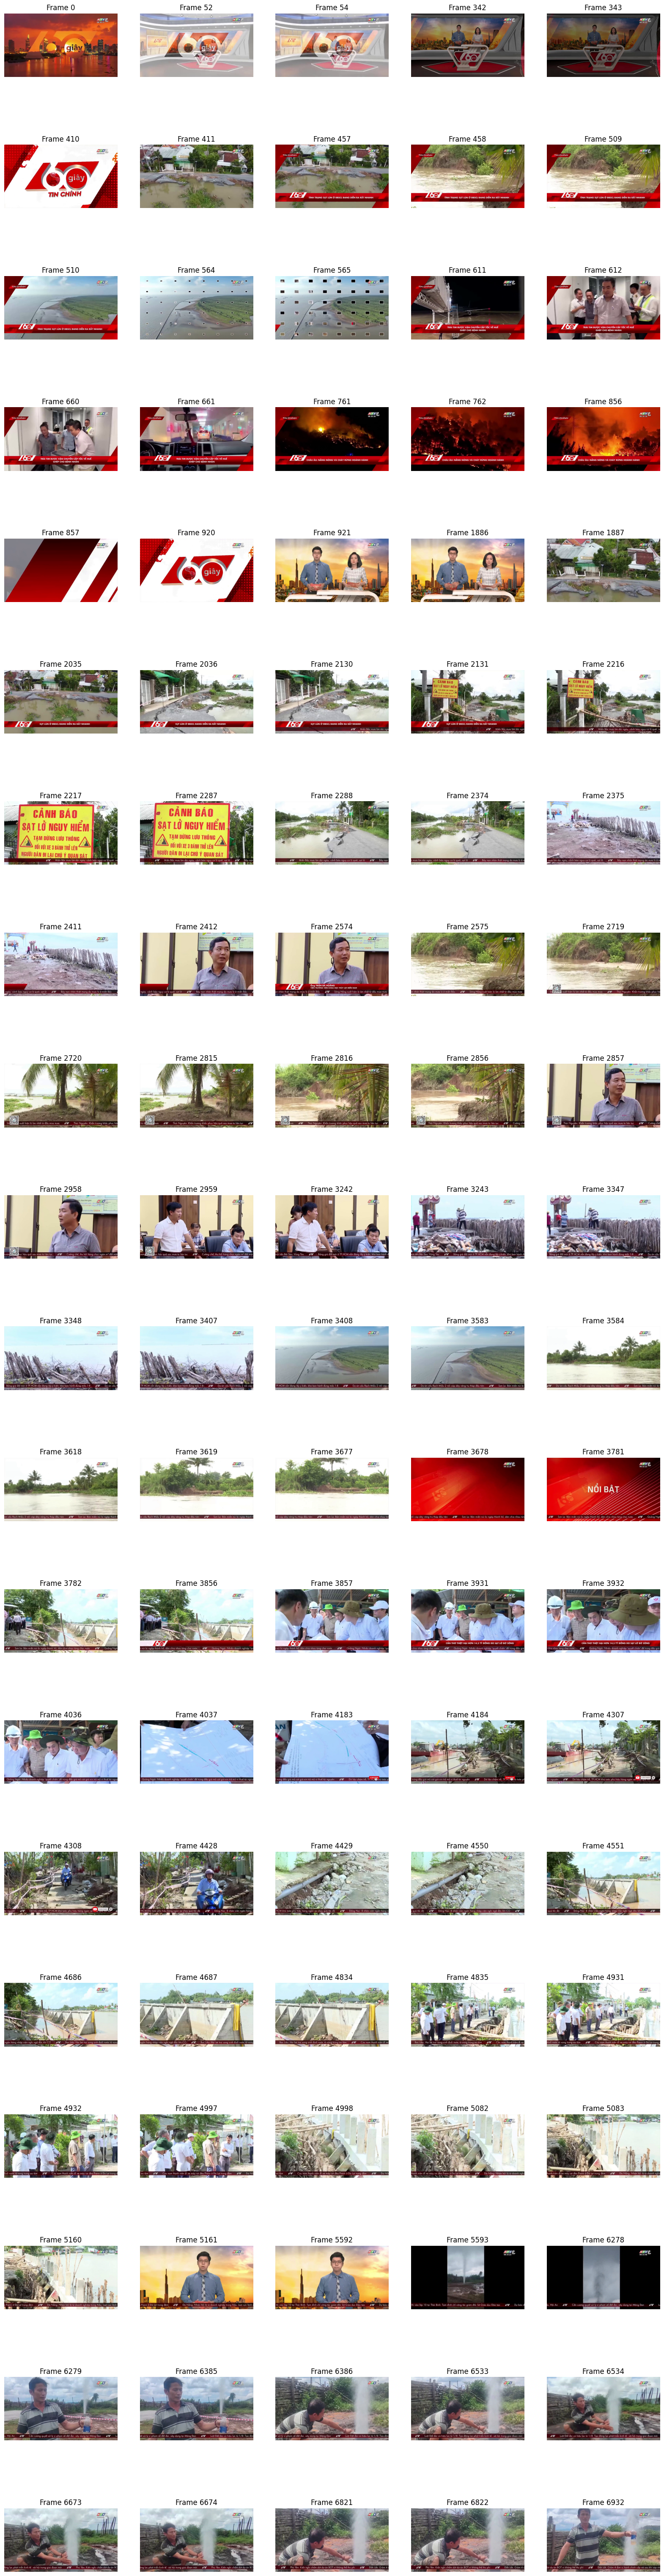

In [11]:
frame_indices = scenes.flatten()
cap = cv2.VideoCapture(video_path)

# Danh sách frame index (lấy từ TransNetV2 output)
frames = []
for f in frame_indices[:100]:
    cap.set(cv2.CAP_PROP_POS_FRAMES, f)
    ret, frame = cap.read()
    if ret:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append((f, frame))

cap.release()

# Plot kết quả
cols = 5
rows = (len(frames) + cols - 1) // cols

plt.figure(figsize=(20, 4*rows))
for i, (idx, frame) in enumerate(frames):
    plt.subplot(rows, cols, i+1)
    plt.imshow(frame)
    plt.axis("off")
    plt.title(f"Frame {idx}")
plt.show()

# Save shot boundary

In [14]:
video_boundary = '/kaggle/working/video_shot_boundary.txt'
with open(video_boundary, "w") as f:
    for row in scenes:
        f.write(f"{row[0]} {row[1]}\n")

print(f"Đã lưu thành công vào {video_boundary}")

Đã lưu thành công vào /kaggle/working/video_shot_boundary.txt
